In [1]:
import numpy as np
import pandas as pd

import data_manipulation as dm
import time
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [79]:
#Import datasets
txn = dm.transactions()
train = dm.train()

#Prep - sort transactions
txn=txn.sort_values(['new_id', 'transaction_date', 'membership_expire_date'])

In [80]:
ul_var = pd.read_csv('final_user_log.csv')

In [81]:
#Check datasets
print(train.shape)
print(txn.shape)
print(ul_var.shape)
print(train['new_id'].nunique())
print(txn['new_id'].nunique())

train['in_txn']=train['new_id'].isin(txn['new_id'])
print(train['in_txn'].value_counts())

(992931, 2)
(16411725, 9)
(992931, 8)
992931
1079663
True    992931
Name: in_txn, dtype: int64


In [82]:
txn=txn[txn['transaction_date']<='2017-01-31']

In [50]:
#Adding some features
txn['in_train']=txn['new_id'].isin(train['new_id'])
txn['odd_transactions']=txn['membership_expire_date']<txn['transaction_date']
txn['1970']=txn['membership_expire_date']=='1970-01-01'
txn['in_train'].value_counts()

True     15030718
False      474576
Name: in_train, dtype: int64

## Investigating Transactions

*Looking into transactions where the membership_expiry_date < transaction_date*

In [5]:
pd.crosstab(index=txn['odd_transactions'], columns=txn['in_train'], normalize='index')

in_train             False     True 
odd_transactions                    
False             0.032114  0.967886
True              0.054375  0.945625

In [6]:
#Odd transactions are more likely to be auto renew transactions
pd.crosstab(index=txn['odd_transactions'], columns=txn['is_auto_renew'], normalize='index')

is_auto_renew            0         1
odd_transactions                    
False             0.089980  0.910020
True              0.004789  0.995211

In [7]:
#Odd transactions are more likely to be cancelled transactions
pd.crosstab(index=txn['odd_transactions'], columns=txn['is_cancel'], normalize='index')

is_cancel                0         1
odd_transactions                    
False             0.986408  0.013592
True              0.047459  0.952541

In [8]:
#397 of the odd transactions are caused by '1970'
pd.crosstab(index=txn['odd_transactions'], columns=txn['1970'], normalize='index')
pd.crosstab(index=txn['odd_transactions'], columns=txn['1970'])

1970                 False  True 
odd_transactions                 
False             16342612      0
True                 68716    397

In [9]:
#226 bad transactions are in the training set
pd.crosstab(index=txn['in_train'], columns=txn['1970'])

1970         False  True 
in_train                 
False       528406    171
True      15882922    226

In [10]:
#0.4% of transactions have membership_expire_date<transaction_date
memb_exp_test=txn[txn['membership_expire_date']<txn['transaction_date']]
print(memb_exp_test.shape[0])
print(txn.shape[0])
print(memb_exp_test.shape[0]/txn.shape[0])
print(txn['new_id'].nunique())
print(memb_exp_test['new_id'].nunique())

69113
16411725
0.00421119656830711
1079663
57069


In [11]:
#Almost all records with membership_expire_date<transaction_date are auto_renew memberships
print(memb_exp_test[memb_exp_test['is_auto_renew']==1]['is_auto_renew'].sum())
print(txn[txn['is_auto_renew']==1].shape)

68782
(14940882, 12)


In [12]:
#Most of the records with membership_expire_date<transaction_date are cancelled memberships - are these late payments?
#ALL of these are also auto-renew memberships
print(memb_exp_test[memb_exp_test['is_cancel']==1]['is_cancel'].sum())
memb_exp_test[(memb_exp_test['is_cancel']==1)&(memb_exp_test['is_auto_renew']==1)].shape

65833


(65833, 12)

In [13]:
#The rest of the auto_renew memberships
memb_exp_test[(memb_exp_test['is_cancel']==0)&(memb_exp_test['is_auto_renew']==1)].shape

(2949, 12)

In [43]:
#Looks like the rest of the records have lots of instances of membership_expire_date = '1970-01-01'
memb_exp_test[memb_exp_test['is_auto_renew']==0].head(10)
#15 records where membership_expire_date is not is not 1970-01-01 and is not auto_renew
odd_ones_out=memb_exp_test[(memb_exp_test['membership_expire_date']!='1970-01-01') & (memb_exp_test['is_auto_renew']==0)]
#Seems like all of these have plan_list_price of 0
odd_ones_out.head(15)

payment_method_id  payment_plan_days  plan_list_price  \
10277170                 26                  1                0   
12088196                 41                  0                0   
10752582                 26                  1                0   
5725996                  26                  1                0   
16397249                 35                  7                0   
16270829                 26                  1                0   
16341684                 35                  7                0   
1916276                  26                  1                0   
11544429                 35                  7                0   
2221659                  26                  1                0   
16266894                 26                  1                0   
16352923                 26                  1                0   
10396995                 26                  0                0   
15055051                 26                  1                0   
15751444                 26                  1                0   

          actual_amount_paid  is_auto_renew transaction_date  \
10277170                   0              0       2015-06-15   
12088196                   0              0       2015-09-18   
10752582                   0              0       2015-01-26   
5725996                    0              0       2015-10-01   
16397249                   0              0       2017-02-20   
16270829                   0              0       2016-09-14   
16341684                   0              0       2017-02-20   
1916276                    0              0       2015-12-19   
11544429                   0              0       2015-08-10   
2221659                    0              0       2016-04-19   
16266894                   0              0       2017-02-15   
16352923                   0              0       2017-02-08   
10396995                   0              0       2015-05-07   
15055051                   0              0       2016-06-14   
15751444                   0              0       2016-09-26   

         membership_expire_date  is_cancel  new_id  in_train  \
10277170             2015-06-14          0    8236      True   
12088196             2014-09-17          0   64925      True   
10752582             2015-01-25          0   77415      True   
5725996              2015-09-30          0  132303      True   
16397249             2017-02-18          0  243122      True   
16270829             2016-09-11          0  321432     False   
16341684             2017-02-17          0  423704      True   
1916276              2015-12-18          0  466084     False   
11544429             2012-02-02          0  502826      True   
2221659              2016-04-17          0  520405      True   
16266894             2017-02-13          0  558906      True   
16352923             2017-02-07          0  768283      True   
10396995             2015-05-06          0  797358      True   
15055051             2016-06-06          0  801450      True   
15751444             2016-09-22          0  823567     False   

          odd_transactions   1970  
10277170              True  False  
12088196              True  False  
10752582              True  False  
5725996               True  False  
16397249              True  False  
16270829              True  False  
16341684              True  False  
1916276               True  False  
11544429              True  False  
2221659               True  False  
16266894              True  False  
16352923              True  False  
10396995              True  False  
15055051              True  False  
15751444              True  False

In [15]:
#is_cancel=txn[txn['is_cancel']==1]
#print(is_cancel.shape)
#is_cancel['diff_dates']=is_cancel['membership_expire_date']-is_cancel['transaction_date']
#is_cancel['diff_dates']=is_cancel['diff_dates']/ np.timedelta64(1, 'D')
#sns.distplot(is_cancel[is_cancel['diff_dates']>0]['diff_dates'])

In [16]:
#Determine if member had an odd transaction
txn['odd_txn_flag'] = txn['new_id'].isin(memb_exp_test['new_id'])

## Feature Engineering
 
<font color='red'>*Note that for the test group, we'll have access to less transactions - using transactions up to March 31st 2017 to predict memberships that expire in April 2017. Therefore, we should train using data up to the end of Feb to predict churn for memberships that expire in the month of March 2017.*</font>

Each transaction feature is stored in a pandas dataframe:

- **txn_cnts (all members)**: Count number of transactions per member; note that this dataframe is no longer included since the transaction count is in the txn_lp_high dataframe
- **tot_plan_pmt (all members)**: Sum of payment plan days, plan list price, and actual amount paid. Also - average price per day, and difference between plan list price and actual amount paid
- **txn_lp_high (all members)**: Count of, and percentage of transactions that have higher list price than actual amount paid
- **txn_prev_churn (churned members)**: Count number of times members churned, i.e. transaction date - membership expire date from previous transaction is greater than 30 days
- **txn_ar_stop (all members)**: % of transactions that are auto renew and whether a member has stopped auto-renewing in the duration of their membership
- **txn_pmt_change (payment change members)**: Count number of times member changed payment type 
- **txn_cancelled (all members)**: % of transactions that are cancelled and whether a members has cancelled their membership in the duration of their membership
- **txn_cancelled_last (all members)**: If the member has a cancelled transaction as their last transaction
- **last_txn (all_members)**: If the member has a free trial as their last transaction

- % of transactions that are free trials
- % of payment plan days that are free trials
- member tenure

All dfs are to be merged into one df, for transaction attributes per member

Next:
- Look at payment plan days - how often are these 0?
- Last transaction is a free trial - free trial and only one transaction: how does this relate to churn?
- Which is the "current" transaction?
- Number of transactions where plan_list_price != actual_amount_paid?
- Transactions matrix


1. Members in train who have membership_expiry date beyond March (for new dataset) - remove, for sure not churn
       How many members have this behaviour?

2. When people have a transaction with membership_expiry_date that is smaller than transaction date, what does the userlog data look like? Are they still listeninging after the membership has supposedly expired?

### Number of Transactions

In [83]:
#Number of transactions
txn_cnts = txn.groupby(['new_id']).size().reset_index(name='txn_cnt')

### Total Payment Plan Days, Plan List Price, Actual Amount Paid

In [84]:
#Sum of payment_plan_days
tot_plan_pmt = txn.groupby(['new_id'])[['payment_plan_days', 'plan_list_price', 'actual_amount_paid']].sum().reset_index()
tot_plan_pmt['avg_daily_paid'] = tot_plan_pmt['actual_amount_paid'] / tot_plan_pmt['payment_plan_days']
tot_plan_pmt['list_actual_diff'] = tot_plan_pmt['plan_list_price'] - tot_plan_pmt['actual_amount_paid']
tot_plan_pmt.head()

new_id  payment_plan_days  plan_list_price  actual_amount_paid  \
0       0                 90              297                 297   
1       1                543             2682                2831   
2       2                720             3576                3725   
3       3                330             1639                1639   
4       4                543             2682                2831   

   avg_daily_paid  list_actual_diff  
0        3.300000                 0  
1        5.213628             65387  
2        5.173611             65387  
3        4.966667                 0  
4        5.213628             65387

### Number, and Percentage of Transactions where Plan List Price Higher than Actual Amount Paid

In [85]:
#Note that plan_list_price is never lower than actual_amount_paid
txn['list_actual_diff'] = txn['plan_list_price'] - txn['actual_amount_paid']
txn_lp_high = txn[txn['list_actual_diff'] > 0].groupby('new_id')['list_actual_diff'].count().reset_index(name='lp_high_cnt')
txn_lp_high = txn_cnts.merge(txn_lp_high, on = 'new_id', how = 'left')
txn_lp_high['per_lp_high'] = txn_lp_high['lp_high_cnt']/txn_lp_high['txn_cnt']
txn_lp_high.head()

new_id  txn_cnt  lp_high_cnt  per_lp_high
0       0        3          NaN          NaN
1       1       19          1.0     0.052632
2       2       25          1.0     0.040000
3       3       11          NaN          NaN
4       4       19          1.0     0.052632

### Number of Times Churned

In [86]:
#Previous churn: determine if transaction date-membership expiry date from previous row is >30days 
txn['shifted_expiry'] = txn.groupby('new_id')['membership_expire_date'].shift()
txn['memb_gap'] = (txn['transaction_date'] - txn['shifted_expiry'])
txn['prev_churn'] = (txn['memb_gap']/np.timedelta64(1, 'D'))>30
txn.head()

payment_method_id  payment_plan_days  plan_list_price  \
867414                   41                 30               99   
867416                   41                 30               99   
867413                   41                 30               99   
15369793                 39                 31              149   
15369798                 39                 31              149   

          actual_amount_paid  is_auto_renew transaction_date  \
867414                    99              1       2016-11-16   
867416                    99              1       2016-12-15   
867413                    99              1       2017-01-15   
15369793                 149              1       2015-01-31   
15369798                 149              1       2015-02-28   

         membership_expire_date  is_cancel  new_id  list_actual_diff  \
867414               2016-12-15          0       0                 0   
867416               2017-01-15          0       0                 0   
867413               2017-02-15          0       0                 0   
15369793             2015-03-19          0       1                 0   
15369798             2015-04-19          0       1                 0   

         shifted_expiry  memb_gap prev_churn  
867414              NaT       NaT      False  
867416       2016-12-15    0 days      False  
867413       2017-01-15    0 days      False  
15369793            NaT       NaT      False  
15369798     2015-03-19  -19 days      False

In [87]:
#Aggregate number of times churned
txn_prev_churn = txn[txn['prev_churn'] == True].groupby('new_id')['prev_churn'].count().reset_index(name='prev_churn_cnt')
txn_prev_churn.head()

new_id  prev_churn_cnt
0       1               1
1       4               1
2       5               1
3       8               2
4       9               1

### Stopped Auto Renew

In [88]:
#Value of 'is_auto_renew' for last transaction
txn_ar_last = txn.groupby(['new_id'])['is_auto_renew'].last().reset_index(name='last_ar')
txn_ar_last['last_ar'].value_counts()

1    890592
0    157574
Name: last_ar, dtype: int64

In [89]:
#Changed auto renew:
txn_ar_change = txn.groupby(['new_id'])['is_auto_renew'].mean().reset_index(name='mean_ar')
txn_ar_stop = txn_ar_change.merge(txn_ar_last, on='new_id', how='inner')
txn_ar_stop['stopped_ar']=(txn_ar_stop['mean_ar'] < 1) & (txn_ar_stop['mean_ar'] > 0) & (txn_ar_stop['last_ar'] == 0)
txn_ar_stop[txn_ar_stop['stopped_ar']==True].head()

new_id   mean_ar  last_ar stopped_ar
9         9  0.571429        0       True
56       56  0.937500        0       True
77       80  0.900000        0       True
131     135  0.714286        0       True
236     243  0.933333        0       True

In [58]:
txn_ar_stop['stopped_ar'].value_counts()

False    1030791
True       17375
Name: stopped_ar, dtype: int64

### Changed Payment Method

In [90]:
#Changed payment method:determine if transaction date-membership expiry date from previous row is >30days 
txn['shifted_pmt'] = txn.groupby('new_id')['payment_method_id'].shift()
txn['pmt_change'] = (txn['payment_method_id'] != txn['shifted_pmt']) & (txn['shifted_pmt'].isnull() != True)
print(txn.head())
txn['pmt_change'].value_counts()

          payment_method_id  payment_plan_days  plan_list_price  \
867414                   41                 30               99   
867416                   41                 30               99   
867413                   41                 30               99   
15369793                 39                 31              149   
15369798                 39                 31              149   

          actual_amount_paid  is_auto_renew transaction_date  \
867414                    99              1       2016-11-16   
867416                    99              1       2016-12-15   
867413                    99              1       2017-01-15   
15369793                 149              1       2015-01-31   
15369798                 149              1       2015-02-28   

         membership_expire_date  is_cancel  new_id  list_actual_diff  \
867414               2016-12-15          0       0                 0   
867416               2017-01-15          0       0                 0

False    15253163
True       252131
Name: pmt_change, dtype: int64

In [91]:
#Aggregate number of times changed payment method
txn_pmt_change = txn[txn['pmt_change'] == True].groupby('new_id')['pmt_change'].count().reset_index(name='pmt_change_cnt')
txn_pmt_change.head()

new_id  pmt_change_cnt
0       7               2
1       8               2
2       9               2
3      21               3
4      36               1

### Cancelled Membership

In [92]:
#Cancelled membership:
txn_cancelled = txn.groupby(['new_id'])['is_cancel'].mean().reset_index(name='mean_cancel')
txn_cancelled['cancelled']=(txn_cancelled['mean_cancel']<1)&(txn_cancelled['mean_cancel']>0)
txn_cancelled[txn_cancelled['cancelled']==True].head()

new_id  mean_cancel cancelled
9        9     0.142857      True
17      17     0.038462      True
21      21     0.074074      True
28      28     0.050000      True
35      35     0.142857      True

In [93]:
txn_cancelled['cancelled'].value_counts()

False    838887
True     209279
Name: cancelled, dtype: int64

In [94]:
#Cancelled membership in last transaction:
txn_cancelled_last = txn.groupby(['new_id'])['is_cancel'].last().reset_index(name='last_cancel')
txn_cancelled_last['last_cancel'].value_counts()

0    1035493
1      12673
Name: last_cancel, dtype: int64

### Last Transaction is Free Trial

In [95]:
#5483 members who have their last transaction as a free trial
last_txn = txn.groupby(['new_id'])['plan_list_price'].last().reset_index(name='last_plan_price')
last_txn['lst_free_trial'] = (last_txn['last_plan_price'] == 0) | (last_txn['last_plan_price'] == 1)
last_txn[last_txn['lst_free_trial']==True].head()

new_id  last_plan_price lst_free_trial
56       56                0           True
309     322                0           True
713     739                0           True
780     809                0           True
989    1027                0           True

## Merging Feature Dataframes

In [96]:
import functools

txn_features = [train, tot_plan_pmt, txn_ar_stop, txn_cancelled, txn_cancelled_last, last_txn]
f_txn = functools.reduce(lambda left,right: pd.merge(left,right,on='new_id', how='inner'), txn_features)

txn_features_left = [f_txn, txn_lp_high, txn_prev_churn, txn_pmt_change]
f_txn = functools.reduce(lambda left,right: pd.merge(left,right,on='new_id', how='left'), txn_features_left)

#.merge(txn_prev_churn, on='new_id', how='left')
#.merge(txn_payment_change, on='new_id', how='left')

print(f_txn.shape)
f_txn.head()

(990834, 21)


is_churn   new_id in_txn  payment_plan_days  plan_list_price  \
0         1  1025093   True                 37              149   
1         1   476532   True                633             3160   
2         1   731853   True                300             1492   
3         1   854199   True                820             1788   
4         1   601853   True                785             3576   

   actual_amount_paid  avg_daily_paid  list_actual_diff   mean_ar  last_ar  \
0                 149        4.027027                 0  0.000000        0   
1                3309        5.227488             65387  0.954545        1   
2                1492        4.973333                 0  0.800000        1   
3                1788        2.180488                 0  0.000000        0   
4                3576        4.555414                 0  0.000000        0   

        ...       mean_cancel  cancelled last_cancel  last_plan_price  \
0       ...          0.000000      False           0              149   
1       ...          0.045455       True           0              149   
2       ...          0.100000       True           1              149   
3       ...          0.000000      False           0             1788   
4       ...          0.000000      False           0              149   

   lst_free_trial txn_cnt  lp_high_cnt  per_lp_high  prev_churn_cnt  \
0           False       2          NaN          NaN             1.0   
1           False      22          1.0     0.045455             1.0   
2           False      10          NaN          NaN             1.0   
3           False       2          NaN          NaN             NaN   
4           False       8          NaN          NaN             NaN   

   pmt_change_cnt  
0             NaN  
1             2.0  
2             1.0  
3             1.0  
4             NaN  

[5 rows x 21 columns]

In [97]:
f_txn.to_csv('final_txn.csv', index=False)

## Casual Exploratory Analysis

Oh so casual *_hairflick_

In [66]:
#4% of transactions have a plan_list_price of zero
txn[txn['plan_list_price']==0]['plan_list_price'].count()/txn['plan_list_price'].count()

0.04360491326381815

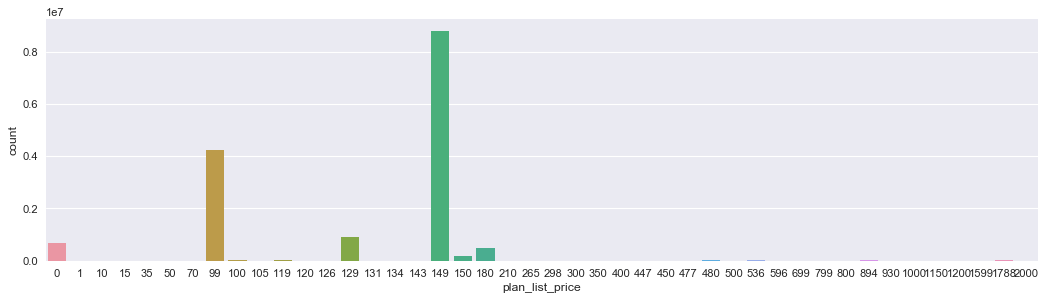

In [67]:
#Looking at prices of membership transactions: 99 & 149 & 129 corresponds to monthly membership
plt.figure(num=None, figsize=(16, 4), dpi=80)
sns.countplot(txn['plan_list_price'])

In [31]:
print(txn[(txn['plan_list_price']==129)|(txn['plan_list_price']==99)|(txn['plan_list_price']==149)]['payment_plan_days'].value_counts())

30    14263933
31      492846
35         325
Name: payment_plan_days, dtype: int64


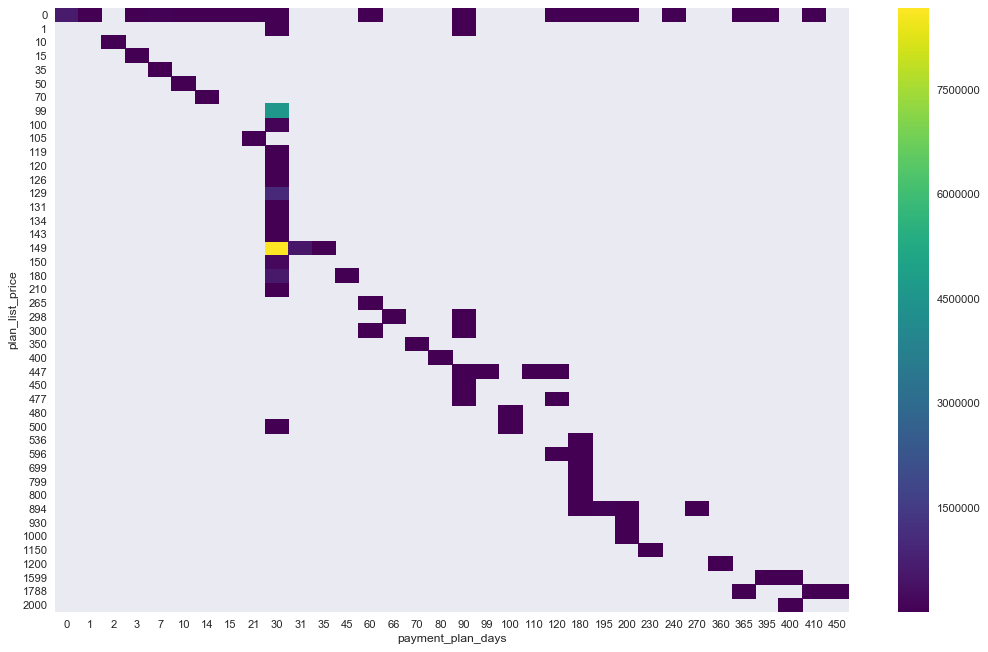

In [32]:
txn_test = txn.groupby(['plan_list_price', 'payment_plan_days'])['plan_list_price'].count().reset_index(name='cnt_txn')
txn_test = txn_test.pivot(index='plan_list_price', columns='payment_plan_days', values='cnt_txn')
plt.figure(num=None, figsize=(16, 10), dpi=80)
sns.heatmap(txn_test, cmap='viridis')

## Are Features Useful?

### Total Payment Plan Days

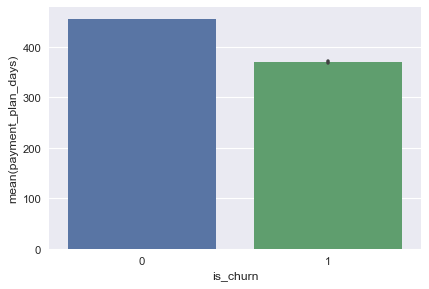

In [68]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'payment_plan_days', data=f_txn)

### Difference Between Listed and Paid Price

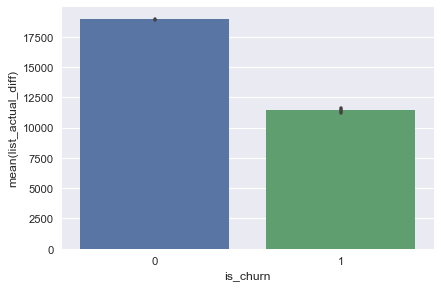

In [69]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'list_actual_diff', data=f_txn)

### Number of Transactions where Plan List Price is Higher than Actual Amount Paid

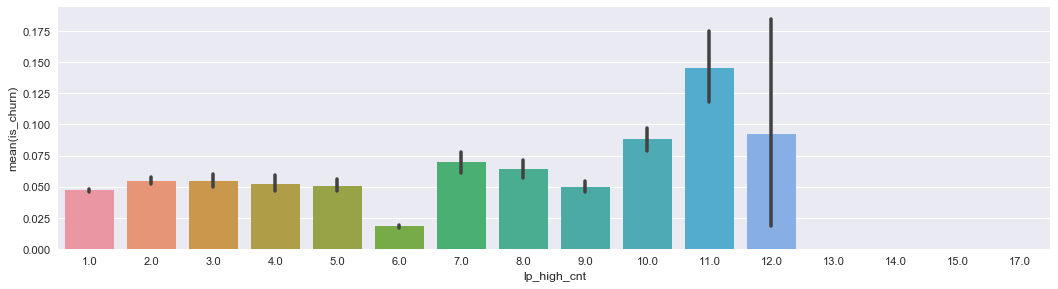

In [70]:
plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('lp_high_cnt', 'is_churn', data=f_txn)

### Percentage of Transactions where Plan List Price is Higher than Actual Amount Paid

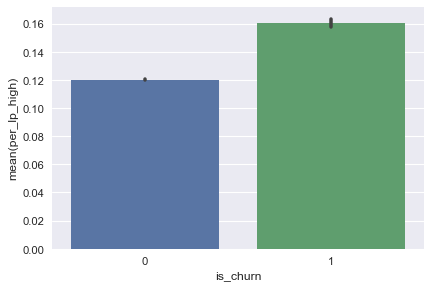

In [71]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'per_lp_high', data=f_txn)

### Previous Churn

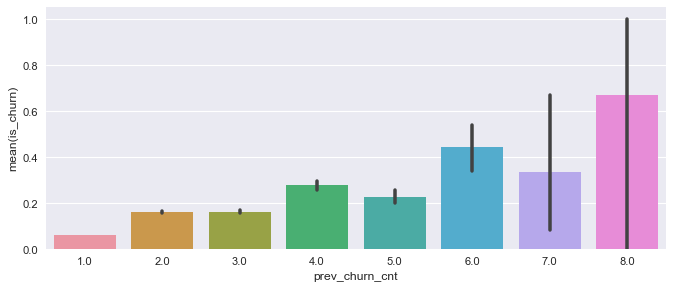

In [72]:
plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('prev_churn_cnt', 'is_churn', data=f_txn)

### % of Transactions as Auto Renew

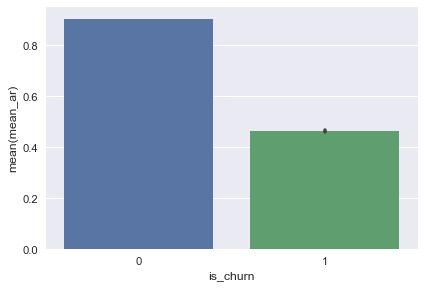

In [73]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'mean_ar', data=f_txn)

### Stopped Auto Renew

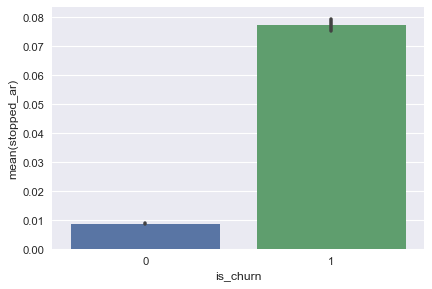

In [74]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'stopped_ar', data=f_txn)

### Changed Payment Methods

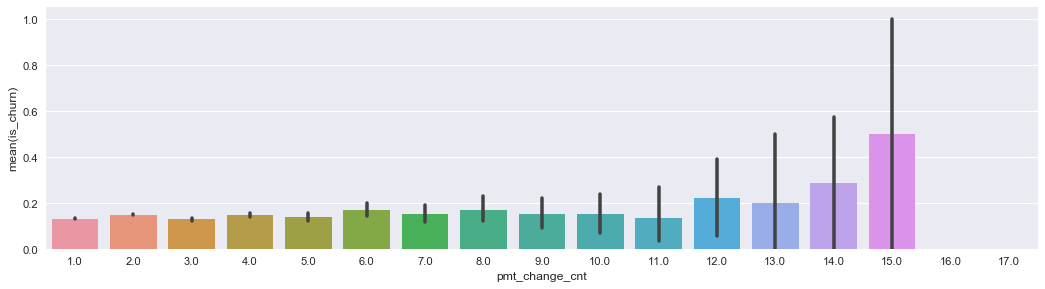

In [75]:
plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('pmt_change_cnt', 'is_churn', data=f_txn)

### % of Transactions Cancelled

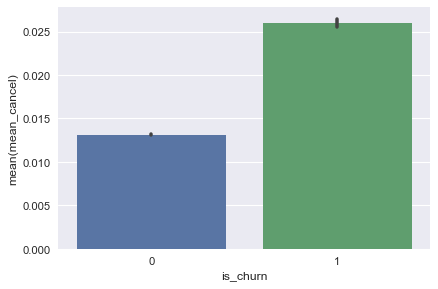

In [76]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'mean_cancel', data=f_txn)

### Last Transaction is Cancelled Transaction

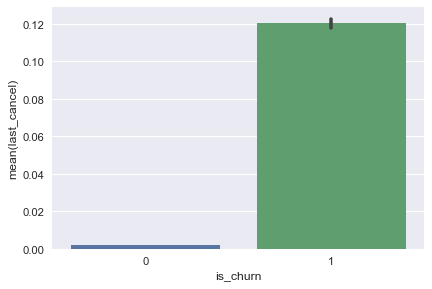

In [77]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'last_cancel', data=f_txn)

### Last Transaction is Free Trial

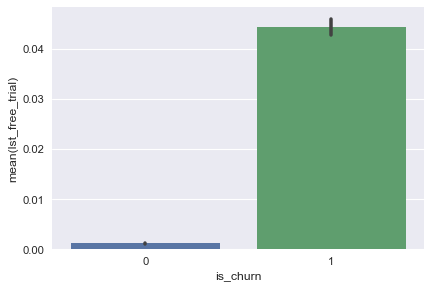

In [78]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'lst_free_trial', data=f_txn)

In [221]:
f_txn.corr()

is_churn    new_id  in_txn  payment_plan_days  \
is_churn            1.000000 -0.001172     NaN          -0.107779   
new_id             -0.001172  1.000000     NaN          -0.000356   
in_txn                   NaN       NaN     NaN                NaN   
payment_plan_days  -0.107779 -0.000356     NaN           1.000000   
plan_list_price    -0.084206  0.000059     NaN           0.956480   
actual_amount_paid -0.090292 -0.000245     NaN           0.931387   
avg_daily_paid      0.028338 -0.000584     NaN           0.245573   
list_actual_diff   -0.063799 -0.000869     NaN           0.465886   
mean_ar            -0.349656 -0.000478     NaN           0.195258   
last_ar            -0.387207 -0.000488     NaN           0.173221   
stopped_ar          0.144484  0.001350     NaN           0.035357   
mean_cancel         0.236278 -0.000709     NaN           0.078673   
cancelled           0.149166 -0.000603     NaN           0.372811   
last_cancel         0.551328 -0.000507     NaN           0.002432   
last_plan_price     0.252641  0.000360     NaN           0.023946   
lst_free_trial      0.189512  0.001320     NaN          -0.044585   
txn_cnt            -0.164563 -0.000492     NaN           0.942243   
lp_high_cnt        -0.017682 -0.002214     NaN          -0.025211   
per_lp_high         0.064005 -0.002698     NaN          -0.392841   
prev_churn_cnt      0.142596 -0.000600     NaN          -0.056035   
pmt_change_cnt      0.009602 -0.002092     NaN           0.159795   

                    plan_list_price  actual_amount_paid  avg_daily_paid  \
is_churn                  -0.084206           -0.090292        0.028338   
new_id                     0.000059           -0.000245       -0.000584   
in_txn                          NaN                 NaN             NaN   
payment_plan_days          0.956480            0.931387        0.245573   
plan_list_price            1.000000            0.984353        0.453698   
actual_amount_paid         0.984353            1.000000        0.546426   
avg_daily_paid             0.453698            0.546426        1.000000   
list_actual_diff           0.542213            0.630314        0.557565   
mean_ar                    0.113743            0.124775       -0.191791   
last_ar                    0.105196            0.114000       -0.160114   
stopped_ar                 0.059208            0.054283        0.068616   
mean_cancel                0.096993            0.072208        0.011720   
cancelled                  0.370941            0.339348        0.075634   
last_cancel                0.005337           -0.000014       -0.006409   
last_plan_price            0.062892            0.062501        0.145065   
lst_free_trial            -0.049157           -0.049232       -0.097249   
txn_cnt                    0.916624            0.922728        0.335306   
lp_high_cnt               -0.026182            0.140295        0.343233   
per_lp_high               -0.392810           -0.248740        0.219217   
prev_churn_cnt            -0.019549           -0.059421       -0.007283   
pmt_change_cnt             0.151625            0.140809       -0.025024   

                    list_actual_diff   mean_ar   last_ar       ...        \
is_churn                   -0.063799 -0.349656 -0.387207       ...         
new_id                     -0.000869 -0.000478 -0.000488       ...         
in_txn                           NaN       NaN       NaN       ...         
payment_plan_days           0.465886  0.195258  0.173221       ...         
plan_list_price             0.542213  0.113743  0.105196       ...         
actual_amount_paid          0.630314  0.124775  0.114000       ...         
avg_daily_paid              0.557565 -0.191791 -0.160114       ...         
list_actual_diff            1.000000  0.135954  0.109368       ...         
mean_ar                     0.135954  1.000000  0.922264       ...         
last_ar                     0.109368  0.922264  1.000000       ...         
stopped_ar    